In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Single(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000)

        rnn_out, _ = self.rnn(V.unsqueeze(2)) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 50000
H_no = 30
device = torch.device("cuda")

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy")
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Single(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3001


In [6]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx])
        test_loss = bce_criterion(test_S_out, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-e92c361a1dd3>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.7646530866622925
49 0.016355523839592934
99 0.0062826466746628284
149 0.004216632805764675
199 0.0033154261764138937
249 0.0028412924148142338
299 0.0025544599629938602
349 0.0023674466647207737
399 0.0022397113498300314
449 0.00214925454929471
499 0.0020834447350353003
549 0.0020342653151601553
599 0.0019961711950600147
649 0.001963467802852392
699 0.0019251953344792128
749 0.0017938404344022274
799 0.001695057493634522
849 0.0016290639759972692
899 0.0015160934999585152
949 0.0014428739668801427
999 0.0014005773700773716
1049 0.0013740163994953036
1099 0.0013536604819819331
1149 0.001336661633104086
1199 0.001322491909377277
1249 0.0013103215023875237
1299 0.0012990207178518176
1349 0.0012896368280053139
1399 0.0012797275558114052
1449 0.0012714096810668707
1499 0.0012659692438319325
1549 0.001259707030840218
1599 0.0012535771820694208
1649 0.0012485957704484463
1699 0.0012434751261025667
1749 0.001239152392372489
1799 0.0012346348958089948
1849 0.0012306907447054982
1899 0.00122

KeyboardInterrupt: 

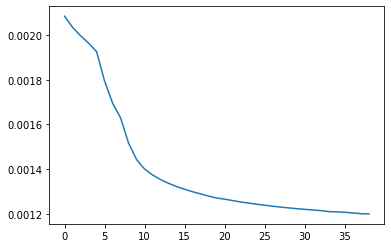

In [8]:
plt.plot(np.asarray(score_list)[10:])

(23000.0, 26000.0)

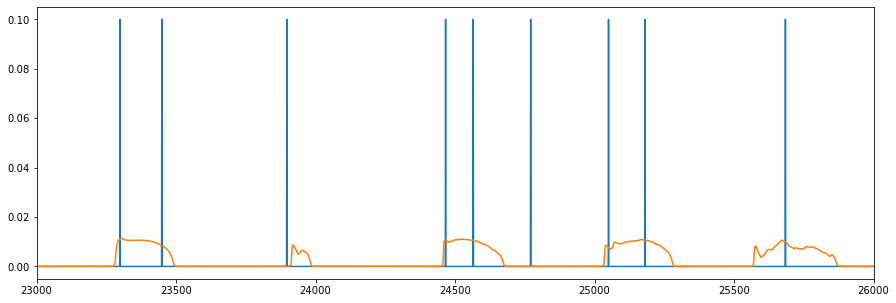

In [10]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx]*0.1)
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h30.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h30_test.npy", test_S_out.cpu().detach().numpy())